In [3]:
#!/usr/bin/env python3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import quad
from scipy.special import hermite
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq

/home/abi/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
#column_names = ['velocity'] #In this case is necesary define the name of the column

In [5]:

df = pd.read_csv('irphe_velocity.dat',delim_whitespace=True, header=None, names=['velocity'])

#print(df)

dt = 1/37500
time =  pd.Series([i*dt for i in range(len(df))])

df['time'] = time

std_total= df['velocity'].std()

#print(df)

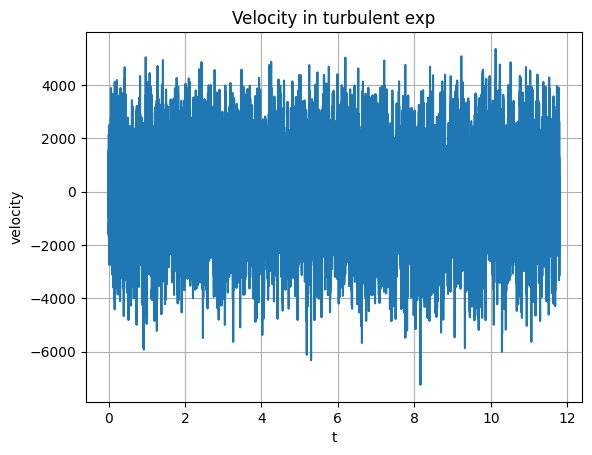

In [6]:
###  PLOT TIME SERIES  #######
plt.plot(df['time'], df['velocity'])
plt.xlabel('t')
plt.ylabel('velocity')
plt.title('Velocity in turbulent exp')
plt.grid(True)
plt.show()


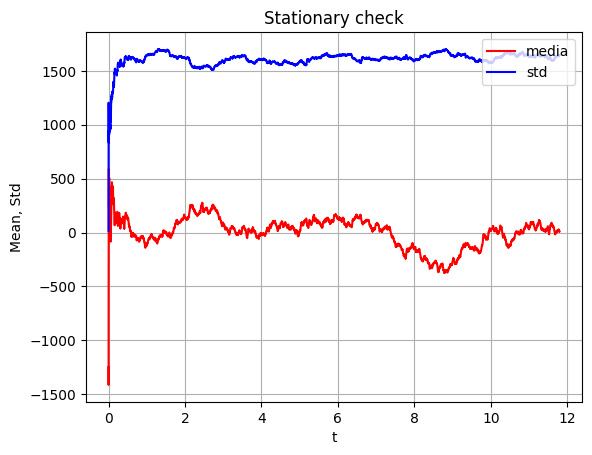

In [7]:
### STATIONARITY CHECK ###################

size_window = len(df) // 10

# Calcular la media y la desviación estándar en cada ventana móvil
mean_window = df['velocity'].rolling(window=size_window, min_periods=1,step=1).mean()
desviation_window = df['velocity'].rolling(window=size_window, min_periods=1,step=1).std()

# Agregar las medias y desviaciones estándar al DataFrame original
df['mean_window'] = mean_window
df['desviation_window'] = desviation_window



 ###GRAFICO SERIE DE TIEMPO DE VELOCIDAD#######
plt.plot(df['time'], df['mean_window'],label='media',color='red')
plt.plot(df['time'], df['desviation_window'],label='std',color='blue')
plt.xlabel('t')
plt.ylabel('Mean, Std')
plt.title('Stationary check')
plt.legend(loc = 'upper right')
plt.grid(True)
plt.show()
 ##########################################
### STATIONARITY CHECK END ###################

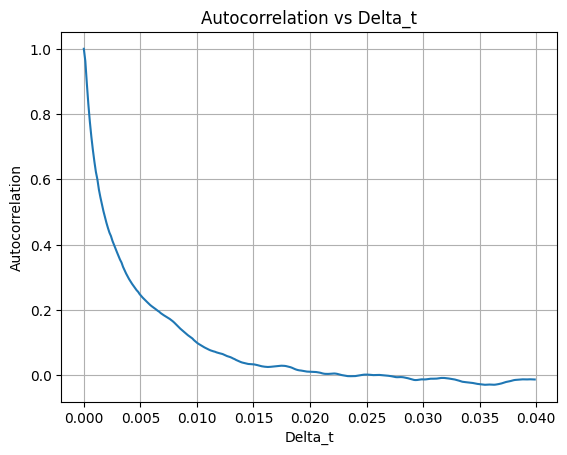

In [8]:
###### AUTOCORRELATION ###########

delta_t_values = [n * dt for n in range(0, size_window + 1, 5)]

autocorelations = []
# normalizacion
#########TRASLADAR TODA LA FUNCION AL CERO 
#print(std_total)

# Calcular la función de autocorrelación para diferentes valores de Delta t

for delta_t in delta_t_values:
   # Desplazar la serie de velocidad en Delta t
    velocity_shifted = df['velocity'].shift(-int(delta_t / dt))
    
  #  Calcular el producto punto entre la serie de velocidad original y la desplazada
    product = df['velocity'] * velocity_shifted
    
    # Calcular la media sobre todo el tiempo t
    autocorrelation = product.mean()/(std_total**2)
    autocorelations.append(autocorrelation)


autocorrelations_df = pd.DataFrame({'Delta_t': delta_t_values, 'Autocorrelation': autocorelations})

# Mostrar el DataFrame de autocorrelaciones
#print(autocorrelaciones_df)

# Graficar la autocorrelación versus el intervalo de tiempo Delta_t
plt.plot(autocorrelations_df['Delta_t'].iloc[:300], autocorrelations_df['Autocorrelation'].iloc[:300])
plt.xlabel('Delta_t')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation vs Delta_t')
plt.grid(True)
plt.show()

###### AUTOCORRELATION END ###########


In [9]:
######### AUTOCORRELATION SCALE ##########

# Supongamos que autocorrelations_df contiene los datos con las autocorrelaciones y delta_t_values contiene los valores de Delta t correspondientes
autocorrelation_scale_total = np.trapz(autocorrelations_df['Autocorrelation'], x=autocorrelations_df['Delta_t'])
print(autocorrelation_scale_total)
# Encontrar el primer cruce por cero en las autocorrelaciones
zero_cross = autocorrelations_df[autocorrelations_df['Autocorrelation'] < 0].index.min()
print(zero_cross,zero_cross*dt)
# Si hay cruce por cero, limitar el DataFrame de autocorrelaciones hasta ese punto
if zero_cross is not None:
    autocorrelations_df_wz = autocorrelations_df.iloc[:zero_cross + 1] ##ajuste exponencial, observar el cruce del ajuste y calcular el tiempo de decaimiento, si es una ezxponencial corresponderia 1/e 
    

# Calcular la integral numérica utilizando la regla del trapecio
autocorrelation_scale = np.trapz(autocorrelations_df_wz['Autocorrelation'], x=autocorrelations_df_wz['Delta_t'])

print("autocorrelation scale:", autocorrelation_scale)


0.005508830431771274
173 0.004613333333333333
autocorrelation scale: 0.0036797953631696597


[2.48059045e+14 2.48059045e+14 2.48059045e+14 ... 3.79761608e+06
 3.79761608e+06 3.79761608e+06]
Parámetros del ajuste:
b = 2.2659047441882785 1.9087666735700928


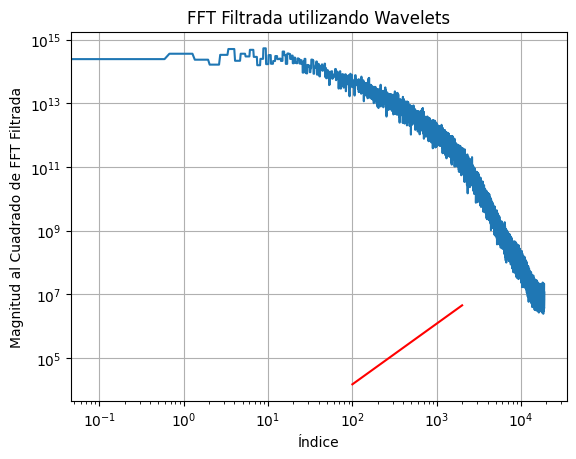

In [13]:
####### POWER LAW ########

from scipy.optimize import curve_fit

# Extraer la serie de velocidad
velocity = df['velocity'].values

# Calcular la Transformada Rápida de Fourier (FFT) de la velocidad
fft_velocity = fft(velocity)
fft_velocity_square= np.abs(fft_velocity)**2
fft_velocity_square_positive= fft_velocity_square[:len(fft_velocity_square)//2]
# Calcular la frecuencia correspondiente a cada punto en la FFT
frecuency = fftfreq(len(velocity), d=dt)
positive_frecuency=frecuency[:len(frecuency)//2]
frecuency_time_scale=1/autocorrelation_scale


######## PRUEBA WAVELETS ##############
import pywt

# Aplicar la transformada wavelet a los datos de la FFT
coeffs = pywt.wavedec(fft_velocity_square_positive, 'db1', level=3)

# Eliminar los coeficientes de alta frecuencia (umbralización)
threshold = 10**16 # Ajustar este valor según sea necesario
coeffs[1:] = (pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:])

# Reconstruir la señal filtrada
filtered_fft_velocity = pywt.waverec(coeffs, 'db1')
print(filtered_fft_velocity)


# Tramar la señal filtrada
#plt.loglog(filtered_fft_velocity)
#plt.xlabel('Índice')
#plt.ylabel('Magnitud al Cuadrado de FFT Filtrada')
#plt.title('FFT Filtrada utilizando Wavelets')
#plt.grid(True)
#plt.show()


###############################

####################### AJUSTE POWER LAW ##########################
# Define la función de la ley de potencias
def power_law(x,a,b):
    return  a*x**b

# Definir el rango de frecuencia en el que deseas ajustar la ley de potencias
# Por ejemplo, si deseas ajustar en el rango de frecuencia entre 10 y 100 Hz:
f_min = 100
f_max = 2*10**3
mask = (positive_frecuency >= f_min) & (positive_frecuency <= f_max)

# Realizar el ajuste de curva utilizando curve_fit
popt, pcov = curve_fit(power_law, positive_frecuency[mask],filtered_fft_velocity[mask])


#popt, pcov = curve_fit(power_law, positive_frecuency[mask], fft_velocity_square_positive[mask])

# Parámetros óptimos del ajuste
a_opt, b_opt = popt
print("Parámetros del ajuste:")

print("b =", a_opt, b_opt)

############################## 
plt.loglog(positive_frecuency,filtered_fft_velocity)
plt.loglog(positive_frecuency[mask], power_law(positive_frecuency[mask],a_opt, b_opt), 'r', label='Ajuste de ley de potencias')

plt.xlabel('Índice')
plt.ylabel('Magnitud al Cuadrado de FFT Filtrada')
plt.title('FFT Filtrada utilizando Wavelets')
plt.grid(True)
plt.show()



#plt.loglog(positive_frecuency, fft_velocity_square_positive)
#plt.loglog(positive_frecuency[mask], power_law(positive_frecuency[mask], a_opt ,b_opt), 'r', label='Ajuste de ley de potencias')

#plt.axvline(x=frecuency_time_scale, color='r', linestyle='--')
#plt.xlabel('Frecuencia')
#plt.ylabel('Magnitud al Cuadrado de FFT')
#plt.title('Transformada de Fourier al Cuadrado vs Frecuencia')
#plt.grid(True)
#plt.show()

Parámetros del ajuste:
a,b = 65311753.97624066 -1.8592105400718892


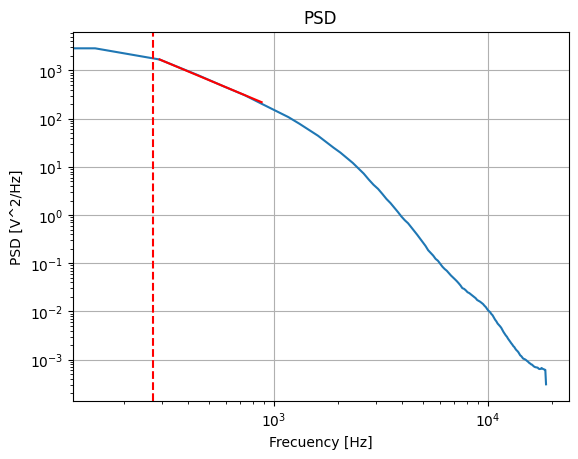

In [11]:
from scipy.signal import welch


# Calcular la densidad espectral de potencia (PSD) utilizando el método de Welch
frequencies, psd = welch(velocity, fs=1/dt)
def power_law(x, a, b):
    return  a*x**b

# Definir el rango de frecuencia en el que deseas ajustar la ley de potencias
# Por ejemplo, si deseas ajustar en el rango de frecuencia entre 10 y 100 Hz:
f_min = frecuency_time_scale
f_max = 1000
mask = (frequencies >= f_min) & (frequencies <= f_max)

# Realizar el ajuste de curva utilizando curve_fit
popt, pcov = curve_fit(power_law, frequencies[mask], psd[mask])

# Parámetros óptimos del ajuste
a_opt, b_opt = popt
print("Parámetros del ajuste:")

print("a,b =", a_opt, b_opt)

# Plotear el espectro de frecuencia
plt.loglog(frequencies, psd)
plt.loglog(frequencies[mask], power_law(frequencies[mask], a_opt,b_opt), 'r', label='Ajuste de ley de potencias')

plt.axvline(x=frecuency_time_scale, color='r', linestyle='--')
plt.xlabel('Frecuency [Hz]')
plt.ylabel('PSD [V^2/Hz]')
plt.title('PSD')
plt.grid(True)
plt.show()

Increment    0.007234
dtype: float64


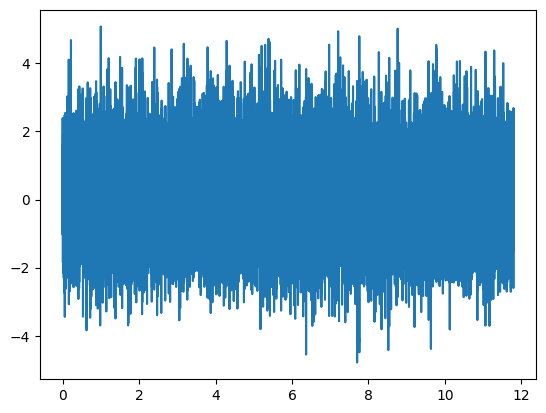

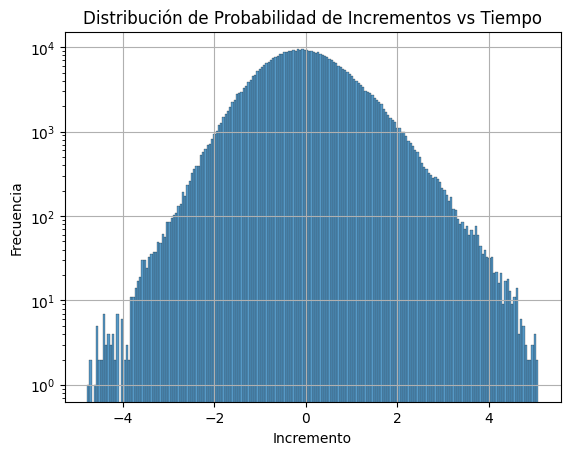

In [15]:
###### INCREMENT ###########
import seaborn as sns
#size_window = len(df) // 10
#delta_t_values = [(2**n) * dt for n in range(0, size_window + 1, 5)]
time =  pd.Series([i*dt for i in range(len(df))])


n= 5
delta_t_values=(2**n) * dt 

# normalizacion
#########TRASLADAR TODA LA FUNCION AL CERO 
#print(std_total)

# Calcular la función de autocorrelación para diferentes valores de Delta t

#for delta_t in delta_t_values:
   # Desplazar la serie de velocidad en Delta t
velocity_shifted = df['velocity'].shift(-int(delta_t_values / dt))
    
  #  Calcular el producto punto entre la serie de velocidad original y la desplazada
diff =  velocity_shifted - df['velocity']
std_diff=diff.std()
    
    # Calcular la media sobre todo el tiempo t
increment = diff/std_diff

increments_df = pd.DataFrame({ 'Increment':increment})
porcentaje_nan = increments_df.isna().mean() * 100
print(porcentaje_nan)

#print(increment , diff, increments_df)

# Mostrar el DataFrame de autocorrelaciones
#print(autocorrelaciones_df)

# Graficar la autocorrelación versus el intervalo de tiempo Delta_t
plt.plot(df['time'], increments_df['Increment'])
#plt.xlabel('Delta_t')
#plt.ylabel('Autocorrelation')
#plt.title('Autocorrelation vs Delta_t')
#plt.grid(True)
plt.show()

sns.histplot(data=increments_df, x='Increment', bins=200)
plt.yscale('log')
plt.xlabel('Incremento')
plt.ylabel('Frecuencia')
plt.title('Distribución de Probabilidad de Incrementos vs Tiempo')
plt.grid(True)
plt.show()

###### AUTOCORRELATION END ###########